# Working with word embeddings

## Importing libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt

## Data Preprocessing
### Getting the data

In [2]:
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label == 'pos':
                labels.append(1)
            else:
                labels.append(0)            

In [3]:
print(texts[1])
print(labels[1])
print(len(texts))

To put it simply, The Fan was a disappointment. It felt like as if I was watching Taxi Driver, except Taxi Driver was much better than this. It seemed like the filmmakers wanted us to root for Robert Deniro's character 100 percent. This approach didn't work.
0
25000


### Tokenizing data

In [4]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('No. of unique tokens: ', str(len(word_index)))

data = pad_sequences(sequences, maxlen=100)

labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of labels tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:200]
x_val = data[200:10200]
y_train = labels[:200]
y_val = labels[200:10200]

No. of unique tokens:  88582
Shape of data tensor:  (25000, 100)
Shape of labels tensor:  (25000,)


## Parsing GloVe word embeddings

In [10]:
glove_file = 'glove.6B.100d.txt'
embeddings_index = {}
f = open(glove_file)
for line in f:
    values = line.split(' ')
    word = values[0]
    coeffs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coeffs
f.close()
print('Found %d word vectors' % len(embeddings_index))

Found 400000 word vectors


## Creating embedding matrix

In [14]:
embedding_matrix = np.zeros((10000, 100))
for word, i in word_index.items():
    if i<10000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Models
### Model 1: Using pretrained embeddings

In [41]:
model1 = Sequential()
model1.add(Embedding(10000, 100, input_length=100))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.layers[0].set_weights([embedding_matrix])
model1.layers[0].trainable = False
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [42]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history1 = model1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)
model1.save_weights('pretrained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/sample - loss: 2.3541 - acc: 0.4750 - val_loss: 0.6928 - val_acc: 0.5139
Epoch 2/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.6503 - acc: 0.6550 - val_loss: 1.5424 - val_acc: 0.4969
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.5526 - acc: 0.7200 - val_loss: 0.6833 - val_acc: 0.5555
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.5041 - acc: 0.7750 - val_loss: 0.7008 - val_acc: 0.5459
Epoch 5/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.3389 - acc: 0.8850 - val_loss: 0.7714 - val_acc: 0.5337
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2016 - acc: 0.9700 - val_loss: 1.9478 - val_acc: 0.5009
Epoch 7/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.3027 - acc: 0.8650 - val_loss: 0.7100 - val_acc: 0.5803
Epoch 8/10
200

### Model 1: Results

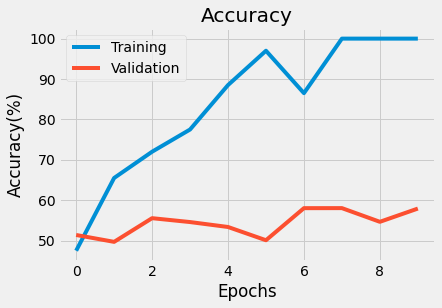

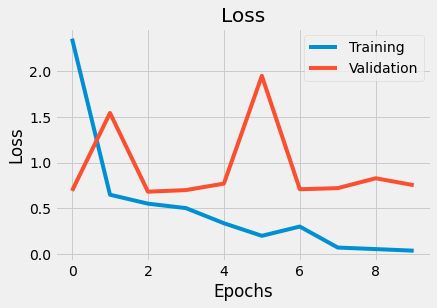

In [43]:
acc1 = history1.history['acc']
acc1 = [i*100 for i in acc1]
val_acc1 = history1.history['val_acc']
val_acc1 = [i*100 for i in val_acc1]
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

plt.figure(1)
plt.style.use('fivethirtyeight')
plt.plot(acc1, label = 'Training')
plt.plot(val_acc1, label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend()

plt.figure(2)
plt.style.use('fivethirtyeight')
plt.plot(loss1, label = 'Training')
plt.plot(val_loss1, label = 'Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Model 2: Without pretrained word embeddings

In [44]:
model2 = Sequential()
model2.add(Embedding(10000, 100, input_length=100))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [45]:
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)
model2.save_weights('trained_embedding_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.6816 - acc: 0.5450 - val_loss: 0.7022 - val_acc: 0.5452
Epoch 2/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.4597 - acc: 0.9650 - val_loss: 0.6995 - val_acc: 0.5420
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2331 - acc: 0.9850 - val_loss: 0.7103 - val_acc: 0.5427
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0985 - acc: 0.9950 - val_loss: 0.7086 - val_acc: 0.5459
Epoch 5/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0453 - acc: 1.0000 - val_loss: 0.7121 - val_acc: 0.5460
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0232 - acc: 1.0000 - val_loss: 0.7249 - val_acc: 0.5451
Epoch 7/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0132 - acc: 1.0000 - val_loss: 0.7271 - val_acc: 0.5475
Epoch 8/10
200

### Model 2: Results

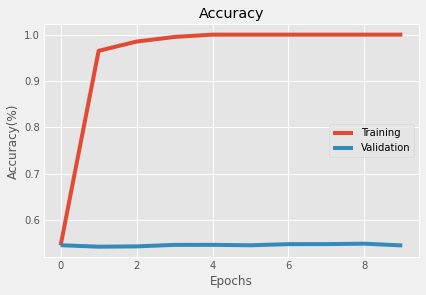

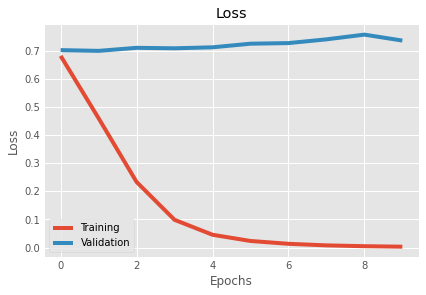

In [50]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(3)
plt.style.use('ggplot')
plt.plot(acc2, label = 'Training')
plt.plot(val_acc2, label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend()

plt.figure(4)
plt.style.use('ggplot')
plt.plot(loss2, label = 'Training')
plt.plot(val_loss2, label = 'Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluating and comparing on test set

In [52]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label == 'pos':
                labels.append(1)
            else:
                labels.append(0)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, 100)
y_test = np.asarray(labels)

model1.evaluate(x_test, y_test)
model2.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 62us/sample - loss: 0.7479 - acc: 0.5395


[0.7478720120429992, 0.53952]